In [12]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
from os.path import join
import torch
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load a bunch of models w/ associated hyperparams from a directory

In [13]:
trained_model_folder = '../models/trained_models'
init_model_folder = '../models/init_models'
trained_list = os.listdir(trained_model_folder)

In [21]:
init_models = os.listdir(init_model_folder)
init_model =torch.load(join(init_model_folder, init_models[0]))
init_comp_model =torch.load(join(init_model_folder, init_models[1]))

In [38]:

fnames = sorted([oj(trained_model_folder, fname) for fname in os.listdir(trained_model_folder)]) # filenames in the directory
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in tqdm(fnames) if "decoy" in fname] 
results = pd.concat(results_list, axis=1).T.infer_objects() # pandas dataframe w/ hyperparams and weights stored


100%|██████████| 17/17 [00:00<00:00, 163.37it/s]
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [39]:
# sanity check: weights should be trained, comp weights should be trained if train both is turned on

# def weights_equivalent(mod1_weights, mod2_weights, names):
#     total_dis =0
#     for layer_name in names:
#         total_dis +=(mod1_weights[weight_layer] -mod1_weights[weight_layer] ).abs().sum()
#     return bool((total_dis !=0).item())
# weight_layers = init_model.state_dict().keys()

# for i in range(len(results)):
#     if not (weights_equivalent(init_model.state_dict(), results.iloc[i]['model_weights'][weight_layer] , weight_layers)):
#         break
#     if results.iloc[i]['train_both']:
#         if not (weights_equivalent(init_comp_model.state_dict(), results.iloc[i]['model_weights'][weight_layer] , weight_layers)):
#             break
# print("All good")

In [40]:
results.keys()

Index(['accs_test', 'accs_train', 'comp_model_weights', 'decoy_strength',
       'explanation_divergence', 'losses_test', 'losses_train',
       'model_weights', 'num_iters', 'out_dir', 'pid', 'seed',
       'signal_strength', 'sparse_signal', 'starting_folder', 'train_both',
       'which_adversarial'],
      dtype='object')

In [41]:
results["final_acc"] = [max(x) for x in results["accs_test"]]
results["final_cd"] = [min(x) for x in results["explanation_divergence"]]


In [42]:
results[[ 'signal_strength', 'final_acc','accs_test', 'final_cd' ]].sort_values(by=['final_acc'])

,signal_strength,final_acc,accs_test,final_cd
1,1.0,55.0,"[52.0, 55.0]",0.545768
0,4.0,58.0,"[58.0, 55.0]",-0.000000
2,0.0,60.0,"[54.0, 60.0]",0.000000


In [35]:
import torch

In [37]:
torch.zeros(1).data

tensor([0.])

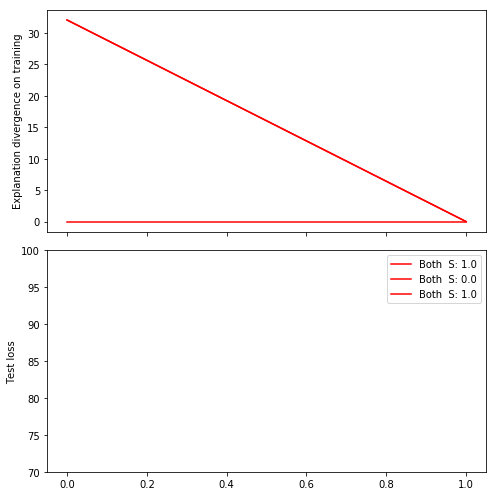

In [34]:
f, axes = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
for idx,div in enumerate(results["explanation_divergence"]):
    label = ""
    color = 'b'
    linestyle = 'solid'
    if results.loc[idx]["sparse_signal"]:
        label+="Sparse "
        linestyle = 'dashed'
    if results.loc[idx]["train_both"]:
        color ='r'
        label+="Both  "
    label+= 'S: '+str(results.loc[idx]["signal_strength"])
    axes[0].plot(div, label = label, c= color,linestyle = linestyle)
    axes[1].plot(results["accs_test"][idx], label = label, c= color,linestyle = linestyle)
 

axes[1].set_ylabel("Test loss")
axes[0].set_ylabel("Explanation divergence on training")
axes[1].set_ylim((70,100))
plt.tight_layout()
plt.legend();

Divergence in explanations goes down for models where both models changed during training (red). Does not go down for models where only one was changed (blue). Test loss (without divergence component) goes up for both.